In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/efficientnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/efficientnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/efficientnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
# make data folders
import os

base_dir = './hamiltonisland-data'


In [3]:
for folder in ['train', 'validation', 'test']:
    for cat in ['published', 'disabled']:
        print('data for {} {}: {}'.format(folder, cat, len(os.listdir(os.path.join(base_dir, folder, cat)))))



data for train published: 580
data for train disabled: 542
data for validation published: 97
data for validation disabled: 109
data for test published: 97
data for test disabled: 106


In [5]:
train_size = len(os.listdir(os.path.join(base_dir, 'train', 'published'))) + len(os.listdir(os.path.join(base_dir, 'train', 'disabled')))

validation_size = len(os.listdir(os.path.join(base_dir, 'validation', 'published'))) + len(os.listdir(os.path.join(base_dir, 'validation', 'disabled')))

test_size = len(os.listdir(os.path.join(base_dir, 'test', 'published'))) + len(os.listdir(os.path.join(base_dir, 'test', 'disabled')))

print('train_size {}, validation_size: {}, test_size {}'.format(train_size, validation_size, test_size))


train_size 1122, validation_size: 206, test_size 203


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

batch_size = 48
width = 224
height = 224
epochs = 50
dropout_rate = 0.2
input_shape = (height, width, 3)


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical',
        shuffle=False
    
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
)

Found 1122 images belonging to 2 classes.
Found 206 images belonging to 2 classes.


batch_index 1
['disabled/5ddd52ee76446daeab4525f0.jpg', 'disabled/5ddd5bb16d8e4eb2c3e3eedd.jpg', 'disabled/5ddd5bb2fe82b3b2d52a40ac.jpg', 'disabled/5ddd8d97195c5bc197ef315e.jpg', 'disabled/5ddd9666ae3d6cc384aa3435.jpg', 'disabled/5ddd9952071adac36f5fdc7d.jpg', 'disabled/5ddd9f350508c1c584a2c9a5.jpg', 'disabled/5ddda0cbcb9e0fc78025b0d0.jpg', 'disabled/5dddb0e82c9429cbb5bb1c01.jpg', 'disabled/5dddc3fac8ffdcd1ff06758e.jpg', 'disabled/5dddd42087a6c4d6118735f1.jpg', 'disabled/5ddddfdd3a4c8eda40deb74c.jpg', 'disabled/5dddea174d96dbdc421b6680.jpg', 'disabled/5dddea1770805ddc257c4d22.jpg', 'disabled/5dddef3ce42705de4d1919d8.jpg', 'disabled/5dddf5d29ebc40e053ea1fbe.jpg', 'disabled/5dddf7499ebc40e053ea21ad.jpg', 'disabled/5dde001d48f463e286b5c34b.jpg', 'disabled/5dde0bd861b95ae69d972916.jpg', 'disabled/5dde0bd861b95ae69d972917.jpg', 'disabled/5dde24cc4f2490eca3975b40.jpg', 'disabled/5dde24cd54d5c7ec959fef50.jpg', 'disabled/5dde3ad55d48b2f30388d7e4.jpg', 'disabled/5dde3ad5a941abf2ed3cb0a4.jpg', '

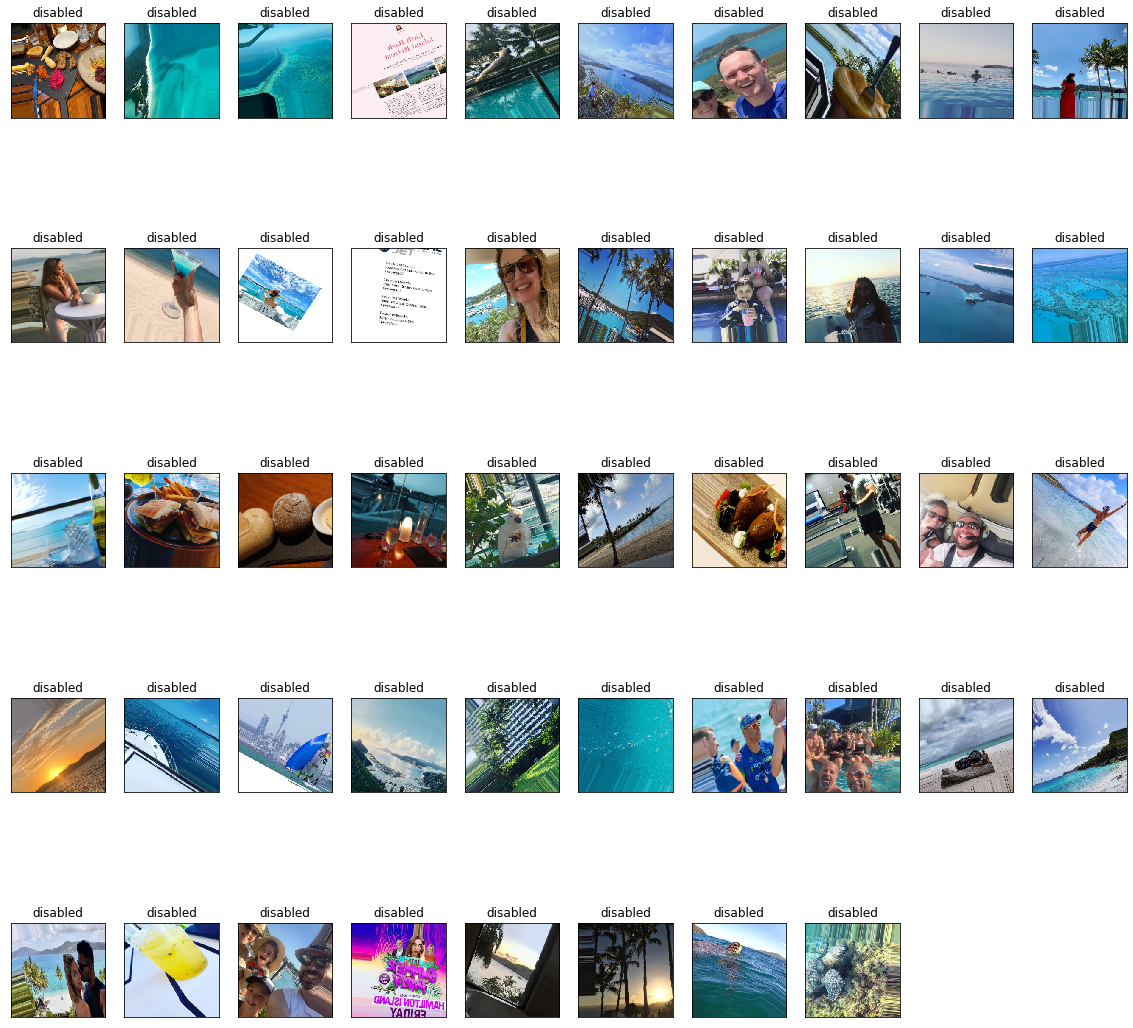

In [8]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


def render_sample(batch_sample_images, batch_sample_labels):
    ncols = 10
    fig = plt.figure(figsize=(20, 20))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(batch_size/ncols + 1, ncols, idx+1, xticks=[], yticks=[])
        image = batch_sample_images[idx]
        plt.imshow(image)    
        ax.set_title('disabled' if batch_sample_labels[idx][0] else 'published')

for x, y in train_generator:
    print('batch_index', train_generator.batch_index)
    idx = (train_generator.batch_index - 1) * train_generator.batch_size
    print(train_generator.filenames[idx : idx + train_generator.batch_size])    
    render_sample(x, y)
    break
    
    



In [9]:
import efficientnet.keras as efn
conv_base = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [10]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

In [11]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [13]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= train_size // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= validation_size // batch_size,
      verbose=1,
      use_multiprocessing=False,
      workers=0)

Epoch 1/50
23/23 [==============================] - 46s 2s/step - loss: 1.1156 - acc: 0.8903 - val_loss: 7.1777 - val_acc: 0.4323
Epoch 2/50
23/23 [==============================] - 41s 2s/step - loss: 1.7111 - acc: 0.8442 - val_loss: 8.1683 - val_acc: 0.3101
Epoch 3/50
23/23 [==============================] - 40s 2s/step - loss: 1.3288 - acc: 0.8712 - val_loss: 7.3290 - val_acc: 0.3924
Epoch 4/50
23/23 [==============================] - 40s 2s/step - loss: 1.2906 - acc: 0.8730 - val_loss: 4.7603 - val_acc: 0.6139
Epoch 5/50
23/23 [==============================] - 40s 2s/step - loss: 1.3165 - acc: 0.8739 - val_loss: 4.6271 - val_acc: 0.6139
Epoch 6/50
23/23 [==============================] - 41s 2s/step - loss: 1.5292 - acc: 0.8531 - val_loss: 6.0516 - val_acc: 0.4323
Epoch 7/50
23/23 [==============================] - 40s 2s/step - loss: 1.3068 - acc: 0.8758 - val_loss: 7.3806 - val_acc: 0.3101
Epoch 8/50
23/23 [==============================] - 40s 2s/step - loss: 1.0664 - acc: 0.89

KeyboardInterrupt: 

In [ ]:
model_save_path = './Efficientnet-hamiltonisland-models'
os.makedirs(model_save_path, exist_ok=True)
model.save(os.path.join(model_save_path, 'hamiltonisland-status.h5'))

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()